<a href="https://colab.research.google.com/github/allen44/riiid-test-answer-prediction/blob/main/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



#Import the data

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv', index_col='row_id')

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#Examine the shape of the dataframe, summary statistics, and missing values

In [3]:
info_fullset = df.info()
info_fullset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int64  
 2   content_id                      int64  
 3   content_type_id                 int64  
 4   task_container_id               int64  
 5   user_answer                     int64  
 6   answered_correctly              int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
dtypes: float64(1), int64(7), object(1)
memory usage: 7.5+ GB


In [4]:
df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [5]:
df.shape

(101230332, 9)

In [6]:
describe_fullset = df.describe(include='all')
describe_fullset

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07,100837826
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89685560
mean,7.703644e+09,1.076732e+09,5.219605e+03,1.935222e-02,9.040624e+02,1.376123e+00,6.251644e-01,2.542381e+04,NaN
std,1.159266e+10,6.197163e+08,3.866359e+03,1.377596e-01,1.358302e+03,1.192896e+00,5.225307e-01,1.994815e+04,NaN
min,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,NaN
25%,5.243436e+08,5.408116e+08,2.063000e+03,0.000000e+00,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04,NaN
50%,2.674234e+09,1.071781e+09,5.026000e+03,0.000000e+00,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04,NaN
75%,9.924551e+09,1.615742e+09,7.425000e+03,0.000000e+00,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04,NaN


##Check for missing data

In [7]:
# Count missing values
df.isna().sum()

timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation     392506
dtype: int64

The data is mostly clean, and only two columns have missing data. Based on the names of these two columns, it seems well have to take a closer look at these two later before handling the missing data.

##Check unique entries and dtypes

In [8]:
#Check the relative frequency of unique values in each column
df.nunique()

timestamp                         72821015
user_id                             393656
content_id                           13782
content_type_id                          2
task_container_id                    10000
user_answer                              5
answered_correctly                       3
prior_question_elapsed_time           3258
prior_question_had_explanation           2
dtype: int64

## Changing dtypes
As the number of unique entries in each column is comparatively low, relative to the size of the data set, there will be perfomance gains by recaasting most of these colums as categorical variables.

timestamp is an exception and should be treated differently.

prior_question_elapsed_time is a float and probably should not be categorical.

prior_question_had_explanation should be change to dtype:bool


In [9]:
categorical_columns = ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly']
for column_id in categorical_columns:
  df[column_id] = pd.Categorical(df[column_id])

df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('bool')
df.dtypes

timestamp                            int64
user_id                           category
content_id                        category
content_type_id                   category
task_container_id                 category
user_answer                       category
answered_correctly                category
prior_question_elapsed_time        float64
prior_question_had_explanation        bool
dtype: object

# Exploring the data in each column

From the Kaggle website:


row_id: (int64) ID code for the row.

timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.

user_id: (int32) ID code for the user.

content_id: (int16) ID code for the user interaction

content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.

task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.

answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.

prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.

prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.





##timestamp

Presumably, this column has something to do with time, but need not be a time series. Let plot to see the distribution of the data, along with summary statistics.

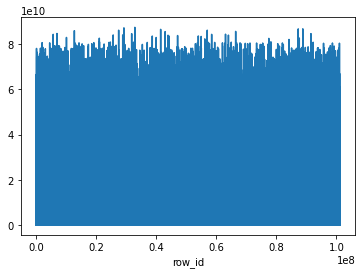

In [10]:
df['timestamp'].plot()
plt.show()

A line plot shows no useful info

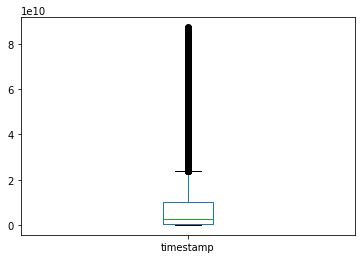

In [11]:
df['timestamp'].plot(kind='box')
plt.show()

A box plot shows that that the timestamps generally have values between 0e9 and 2e9, with a minority of values larger than 2.

As 10e8 is about 3.1 years, and 10e7 is about 0.31 years,

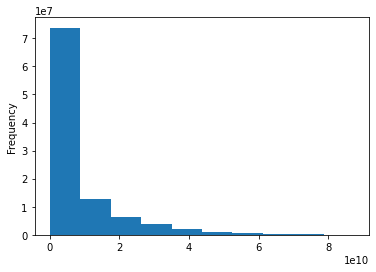

In [12]:
df['timestamp'].plot(kind='hist', bins=10)
plt.show()

There is a right-skewness but no reason yet to consider these as outliers to drop or correct.

Most of the data entries were from relatively "young" user accounts, while a minority of data are from older user accounts. The units here are milliseconds since account creations, so the average action took place about 0.23 years after account creation.

##user_id

This is presumed to a unique user id that is randomly distributed to each user, with one per user.

This data can be used to relate data etries from the same users through out the data set.


In [13]:
#Count the unique users in this data set
unique_users = df['user_id'].unique()
unique_users

[115, 124, 2746, 5382, 8623, ..., 2147470770, 2147470777, 2147481750, 2147482216, 2147482888]
Length: 393656
Categories (393656, int64): [115, 124, 2746, 5382, ..., 2147470777, 2147481750, 2147482216,
                             2147482888]

unique_users is an np.array of types int, buit is not continuous and very few of the numbers in the range are used.

In [14]:
len(unique_users)

393656

As there are not that many users, while the int range is large, there may be a performance benefit to convert this data type to Category.

In [15]:
df['user_id'] = df['user_id'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   timestamp                       int64   
 1   user_id                         category
 2   content_id                      category
 3   content_type_id                 category
 4   task_container_id               category
 5   user_answer                     category
 6   answered_correctly              category
 7   prior_question_elapsed_time     float64 
 8   prior_question_had_explanation  bool    
dtypes: bool(1), category(6), float64(1), int64(1)
memory usage: 3.4 GB


We can see that the user_id column now has dtype: category.

We can  group the rows by user_id now by using a multi-index

In [16]:
df = df.set_index('user_id', 'timestamp')
df.head()

,timestamp,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
user_id,,,,,,,,
115,0,5692,0,1,3,1,NaN,True
115,56943,5716,0,2,2,1,37000.0,False
115,118363,128,0,0,0,1,55000.0,False
115,131167,7860,0,3,0,1,19000.0,False
115,137965,7922,0,4,1,1,11000.0,False


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 101230332 entries, 115 to 2147482888
Data columns (total 8 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   timestamp                       int64   
 1   content_id                      category
 2   content_type_id                 category
 3   task_container_id               category
 4   user_answer                     category
 5   answered_correctly              category
 6   prior_question_elapsed_time     float64 
 7   prior_question_had_explanation  bool    
dtypes: bool(1), category(5), float64(1), int64(1)
memory usage: 2.7 GB


In [18]:
df.shape

(101230332, 8)

We see that there is only less column now.

#Detour
As the Google Colab runtime keeps crashing due to lack of memory (even with Colab Pro), we will switch to importing only about 1% of the data for this EDA. IF we see that this subset differs signifcant;y fullset's summary statistics, we can contiue to attempt using the full set.

In [19]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/riiid-test-answer-prediction/data/train.csv', index_col='row_id', nrows=10**6)

In [20]:
info_subset = df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   timestamp                       1000000 non-null  int64  
 1   user_id                         1000000 non-null  int64  
 2   content_id                      1000000 non-null  int64  
 3   content_type_id                 1000000 non-null  int64  
 4   task_container_id               1000000 non-null  int64  
 5   user_answer                     1000000 non-null  int64  
 6   answered_correctly              1000000 non-null  int64  
 7   prior_question_elapsed_time     976277 non-null   float64
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float64(1), int64(7), object(1)
memory usage: 76.3+ MB


In [21]:
describe_subset = df.describe(include='all')
describe_subset

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
count,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,976277.000000,996184
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889887
mean,7.344311e+09,1.017255e+07,5232.691523,0.019907,806.105689,1.374784,0.617504,25302.962693,NaN
std,1.058693e+10,6.029234e+06,3882.323419,0.139681,1025.887530,1.194168,0.525364,19710.310227,NaN
min,0.000000e+00,1.150000e+02,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,NaN
25%,5.211669e+08,4.702585e+06,2057.000000,0.000000,109.000000,0.000000,0.000000,16000.000000,NaN
50%,2.824811e+09,9.678259e+06,5052.000000,0.000000,391.000000,1.000000,1.000000,21000.000000,NaN
75%,1.010186e+10,1.556872e+07,7421.000000,0.000000,1112.000000,3.000000,1.000000,29666.000000,NaN


In [22]:
df.nunique()

timestamp                         769357
user_id                             3824
content_id                         13320
content_type_id                        2
task_container_id                   7740
user_answer                            5
answered_correctly                     3
prior_question_elapsed_time         1659
prior_question_had_explanation         2
dtype: int64

##content_id
content_id: (int16) ID code for the user interaction

We can probably recast this as categorical also.

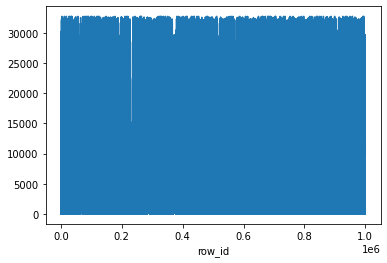

In [23]:
df['content_id'].plot()
plt.show()